In [50]:
# Import pandas for data loading, cleaning, and manipulation
import pandas as pd
# Import matplotlib for creating static visualizations
import matplotlib.pyplot as plt
# Import plotly for interactive and presentation-quality visualizations
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Import seaborn for statistical and distribution-based visualizations
import seaborn as sns
# Import networkx for network visualizations
import networkx as nx

# Helper: safe Plotly display for environments missing nbformat
# If the default renderer fails (nbformat/ipython not available),
# fallback to an HTML export shown via IPython.display.HTML.
import plotly.io as pio
from IPython.display import HTML, display
def safe_show(fig):
    """Render a Plotly figure as standalone HTML and display it."""
    # Use HTML export to avoid nbformat/ipython renderer issues
    html = pio.to_html(fig, include_plotlyjs="cdn", full_html=False)
    display(HTML(html))

**1. Long-Term Growth of Alliance Networks**

In [51]:
# Load the Correlates of War alliance dataset (dyad-year level) into a DataFrame
# Each row represents an alliance relationship between two states in a given year
df = pd.read_csv("/Users/snareddy/Desktop/PROJECTS/Story Telling/Datasets/alliance_v4.1_by_dyad_yearly.csv")
df.head()


,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,year,version
0,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1816,4.1
1,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1817,4.1
2,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1818,4.1
3,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1819,4.1
4,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1820,4.1


In [52]:
# Select only the columns required for the analysis
# - year: time dimension
# - ccode1, ccode2: country codes forming each dyad
# - defense, neutrality, nonaggression, entente: alliance commitment types
# This step improves data relevance and reduces unnecessary complexity
cols_needed = [
    "year",
    "ccode1",
    "ccode2",
    "defense",
    "neutrality",
    "nonaggression",
    "entente"
]
df = df[cols_needed]
df.head()


,year,ccode1,ccode2,defense,neutrality,nonaggression,entente
0,1816,200,235,1,0,1.0,0.0
1,1817,200,235,1,0,1.0,0.0
2,1818,200,235,1,0,1.0,0.0
3,1819,200,235,1,0,1.0,0.0
4,1820,200,235,1,0,1.0,0.0


In [53]:
# Check for missing values in each column of the dataset
# This step is used to assess data quality and identify fields
# that may require cleaning or imputation before analysis
df.isnull().sum()

year              0
ccode1            0
ccode2            0
defense           0
neutrality        0
nonaggression    21
entente          12
dtype: int64

In [54]:
# Replace missing values in nonaggression and entente columns with 0
# Missing values indicate the absence of that alliance type for a dyad-year
# Filling with 0 ensures these columns can be safely treated as binary indicators
df["nonaggression"] = df["nonaggression"].fillna(0)
df["entente"] = df["entente"].fillna(0)
df.isnull().sum()


year             0
ccode1           0
ccode2           0
defense          0
neutrality       0
nonaggression    0
entente          0
dtype: int64

In [55]:
# Convert the 'year' column to integer type
# This ensures the year field is treated correctly for grouping and plotting
df["year"] = df["year"].astype(int)

# Aggregate the data by year to count the number of active alliance dyads per year
# Each row in the original data represents one alliance dyad in a given year,
# so counting rows per year gives total alliance activity for that year
alliances_per_year = (
    df.groupby("year")
      .size()
      .reset_index(name="num_alliances")
)
alliances_per_year.head()


,year,num_alliances
0,0,45
1,1816,39
2,1817,39
3,1818,39
4,1819,39


In [56]:
# Define a function to categorize each year into a major historical period
# These periods correspond to key phases in global political history
def assign_period(year):
    if year < 1914:
        return "Pre-WWI (1816–1913)"
    elif year < 1945:
        return "World Wars (1914–1945)"
    elif year < 1991:
        return "Cold War (1946–1990)"
    else:
        return "Post-Cold War (1991–2012)"

# Apply the period classification to each row based on the year
# This creates a new categorical column used for period-wise comparison
df["period"] = df["year"].apply(assign_period)

In [57]:
# Aggregate the total number of alliance dyad-years for each historical period
# This counts how many alliance observations fall within each period
period_alliance_years = (
    df.groupby("period")
      .size()
      .reset_index(name="total_alliance_years")
)
# Compute the number of unique years within each historical period
# This is required to normalize alliance counts by period length
years_per_period = (
    df.groupby("period")["year"]
      .nunique()
      .reset_index(name="num_years")
)

In [58]:
# Merge alliance counts and period lengths into a single summary table
# This combines total alliance activity with the number of years in each period
period_summary = pd.merge(
    period_alliance_years,
    years_per_period,
    on="period"
)
# Compute the average number of active alliances per year for each period
# This normalizes alliance activity by period length, enabling fair comparison
period_summary["avg_alliances_per_year"] = (
    period_summary["total_alliance_years"] /
    period_summary["num_years"]
)

In [59]:
# Define a logical chronological order for the historical periods
# This ensures periods appear in the correct sequence in tables and plots
period_order = [
    "Pre-WWI (1816–1913)",
    "World Wars (1914–1945)",
    "Cold War (1946–1990)",
    "Post-Cold War (1991–2012)"
]
# Convert the 'period' column into an ordered categorical variable
# This enforces the custom chronological order rather than alphabetical sorting
period_summary["period"] = pd.Categorical(
    period_summary["period"],
    categories=period_order,
    ordered=True
)
# Sort the summary table using the defined chronological order
period_summary = period_summary.sort_values("period")

In [60]:
period_summary.head()

,period,total_alliance_years,num_years,avg_alliances_per_year
2,Pre-WWI (1816–1913),3470,99,35.050505
3,World Wars (1914–1945),3504,31,113.032258
0,Cold War (1946–1990),34985,46,760.543478
1,Post-Cold War (1991–2012),32170,22,1462.272727


In [61]:
# Create a bar chart using Plotly to visualize average alliance activity by historical period
# This chart compares normalized alliance intensity across periods of different lengths
fig = px.bar(
    period_summary,
    x="period",
    y="avg_alliances_per_year",
    title="Average Number of Active Alliances per Year by Historical Period",
    labels={
        "period": "Historical Period",
        "avg_alliances_per_year": "Average Active Alliances per Year"
    }
)
# Adjust the x-axis label orientation for better readability
fig.update_layout(
    xaxis_tickangle=0
)
# Display the interactive plot
safe_show(fig)

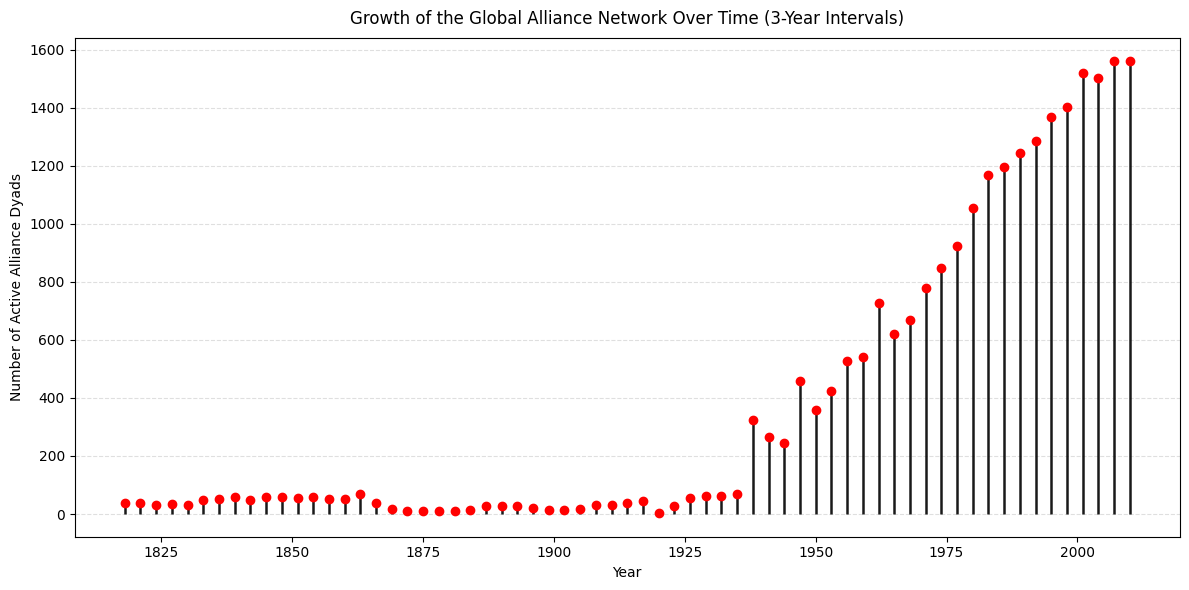

In [62]:
# Filter the alliance count data to include years between 1816 and 2012
# and sample the data at regular 3-year intervals to reduce visual clutter
alliances_5yr = alliances_per_year[
    (alliances_per_year["year"] >= 1816) &
    (alliances_per_year["year"] <= 2012) &
    (alliances_per_year["year"] % 3 == 0)
]
# Initialize the figure for the lollipop chart
plt.figure(figsize=(12, 6))

# Extract year and alliance count values for plotting
x = alliances_5yr["year"]
y = alliances_5yr["num_alliances"]

# Draw vertical lines (stems) from zero to the alliance count for each year
# These represent the magnitude of alliance activity at each interval
plt.vlines(
    x=x,
    ymin=0,
    ymax=y,
    color="black",
    linewidth=1.8,
    alpha=0.9
)

# Plot circular markers at the top of each stem (lollipop heads)
# These emphasize individual data points along the timeline
plt.plot(
    x,
    y,
    "o",
    color="red",
    markersize=6
)

# Label the axes to clarify the dimensions of the chart
plt.xlabel("Year")
plt.ylabel("Number of Active Alliance Dyads")

# Add a descriptive title indicating the temporal resolution used
plt.title(
    "Growth of the Global Alliance Network Over Time (3-Year Intervals)",
    pad=10
)
# Save the figure for reproducibility and report inclusion
plt.savefig("lollipop_chart.png", dpi=300, bbox_inches='tight')
# Add a light horizontal grid to improve readability
plt.grid(axis="y", linestyle="--", alpha=0.4)
# Adjust layout to prevent clipping of labels
plt.tight_layout()
# Display the plot
plt.show()

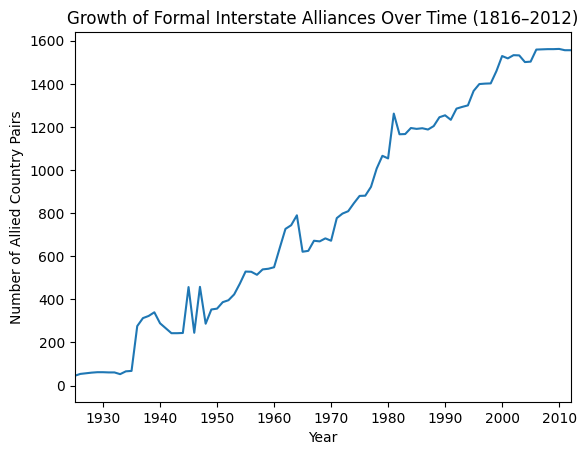

In [63]:
# Create a new figure for a simple line plot
# This visualization shows the overall trend in alliance formation over time
plt.figure()

# Plot the number of active alliance dyads against year
# This provides a continuous view of alliance growth across the full timeline
plt.plot(
    alliances_per_year["year"],
    alliances_per_year["num_alliances"]
)

# Add a descriptive title to contextualize the trend
plt.title("Growth of Formal Interstate Alliances Over Time (1816–2012)")

# Label the axes for clarity
plt.xlabel("Year")
plt.ylabel("Number of Allied Country Pairs")

# Restrict the x-axis to the post-1925 period
# This focuses attention on the era of rapid alliance expansion
plt.xlim(1925, 2012)

# Display the plot
plt.show()

**2. World Wars and the Transformation of Alliance Commitments**

In [64]:
# Select only the columns relevant for Hypothesis 2
# - year: time dimension
# - defense: high-commitment alliance indicator
# - nonaggression, entente: low-commitment alliance indicators
# A separate dataframe is created to keep Hypothesis 2 analysis isolated
cols_needed = ["year", "defense", "nonaggression", "entente"]
df_h2 = df[cols_needed].copy()

# Check for missing values in the selected columns
# This helps assess data quality before defining commitment categories
df_h2.isnull().sum()

year             0
defense          0
nonaggression    0
entente          0
dtype: int64

In [65]:
# Replace missing values in alliance commitment columns with 0
# Missing values indicate the absence of that alliance type for a given dyad-year
# Converting to integers ensures these fields behave as binary indicators
df_h2[["defense", "nonaggression", "entente"]] = (
    df_h2[["defense", "nonaggression", "entente"]]
    .fillna(0)
    .astype(int)
)
# Preview the cleaned Hypothesis 2 dataset
df_h2.head()

,year,defense,nonaggression,entente
0,1816,1,1,0
1,1817,1,1,0
2,1818,1,1,0
3,1819,1,1,0
4,1820,1,1,0


In [66]:
# Apply the period classification to the Hypothesis 2 dataframe
# This adds historical context to each dyad-year observation
df_h2["period"] = df_h2["year"].apply(assign_period)

# Aggregate alliance commitments by historical period
# Sums the number of defense, non-aggression, and entente agreements within each period
# This allows comparison of commitment types across different historical phases
period_type_counts = (
    df_h2
    .groupby("period")[["defense", "nonaggression", "entente"]]
    .sum()
    .reset_index()
)

In [67]:
# Aggregate alliance commitment types by year
# This sums the number of defense, non-aggression, and entente agreements
# across all dyads for each year
yearly_type_counts = (
    df_h2
    .groupby("year")[["defense", "nonaggression", "entente"]]
    .sum()
    .reset_index()
)

# Filter the yearly data to 5-year intervals between 1816 and 2012
# This temporal sampling reduces noise and improves visual interpretability
yearly_5yr = yearly_type_counts.loc[
    (yearly_type_counts["year"] >= 1816) &
    (yearly_type_counts["year"] <= 2012) &
    (yearly_type_counts["year"] % 5 == 0)
].copy()

In [68]:
# Compute the total number of alliance dyad-years for each sampled year
# This represents overall alliance activity in that year across all commitment types
yearly_5yr["total"] = (
    yearly_5yr["defense"] +
    yearly_5yr["nonaggression"] +
    yearly_5yr["entente"]
)

# Convert raw alliance counts into proportional shares
# Normalization allows comparison of commitment composition over time,
# independent of changes in total alliance volume
yearly_5yr["defense_share"] = yearly_5yr["defense"] / yearly_5yr["total"]
yearly_5yr["nonaggression_share"] = yearly_5yr["nonaggression"] / yearly_5yr["total"]
yearly_5yr["entente_share"] = yearly_5yr["entente"] / yearly_5yr["total"]

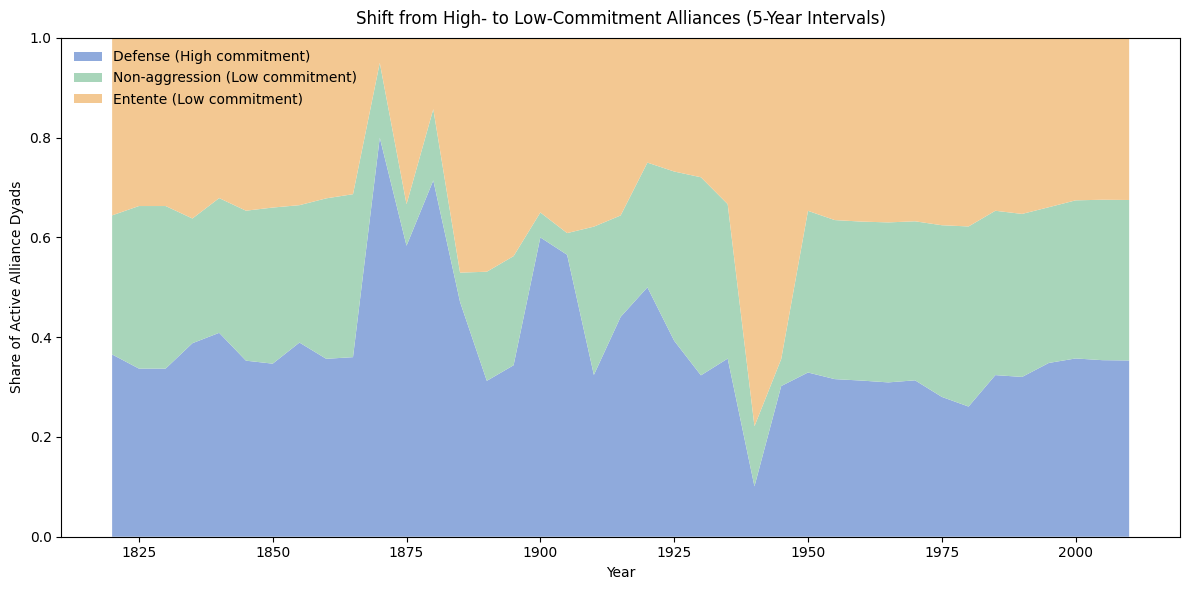

In [69]:
# Initialize the figure for the stacked area chart
# This visualization is used to show how alliance commitment composition changes over time
plt.figure(figsize=(12, 6))

# Create a stacked area plot using normalized commitment shares
# Each layer represents the proportion of a specific alliance type in a given year
plt.stackplot(
    yearly_5yr["year"],
    yearly_5yr["defense_share"],
    yearly_5yr["nonaggression_share"],
    yearly_5yr["entente_share"],
    labels=[
        "Defense (High commitment)",
        "Non-aggression (Low commitment)",
        "Entente (Low commitment)"
    ],
    colors=["#8FAADC", "#A8D5BA", "#F3C892"]  # soft, report-safe colors
)

# Add a descriptive title explaining the analytical focus of the chart
plt.title("Shift from High- to Low-Commitment Alliances (5-Year Intervals)", pad=10)

# Label axes to clarify time and measurement scale
plt.xlabel("Year")
plt.ylabel("Share of Active Alliance Dyads")

# Constrain the y-axis to reflect proportional shares (0–100%)
plt.ylim(0, 1)

# Add a legend to identify commitment types
plt.legend(loc="upper left", frameon=False)

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Display the final visualization
plt.show()

In [70]:
# Create a separate dataframe focused on alliance commitment types
# This isolates the variables needed to classify high- vs low-commitment alliances
df_commitment = df[["year", "defense", "nonaggression", "entente"]].copy()

# Handle missing values in commitment indicators
# Missing values indicate absence of that alliance type and are set to 0
# Converting to integers ensures these columns behave as binary flags
df_commitment[["defense", "nonaggression", "entente"]] = (
    df_commitment[["defense", "nonaggression", "entente"]]
    .fillna(0)
    .astype(int)
)

# Define high-commitment alliances
# Defense pacts represent binding military commitments
df_commitment["high_commitment"] = df_commitment["defense"]

# Define low-commitment alliances (mutually exclusive)
# A dyad-year is classified as low-commitment if:
# - it is NOT a defense pact, and
# - it includes either a non-aggression pact or an entente
df_commitment["low_commitment"] = (
    (df_commitment["defense"] == 0) &
    (
        (df_commitment["nonaggression"] == 1) |
        (df_commitment["entente"] == 1)
    )
).astype(int)

In [71]:
# Aggregate commitment categories by year
# This sums the number of high-commitment and low-commitment dyad-years for each year
yearly_commitment = (
    df_commitment
    .groupby("year")[["high_commitment", "low_commitment"]]
    .sum()
    .reset_index()
)

# Filter the yearly data to 5-year intervals between 1816 and 2012
# This sampling reduces noise and improves clarity in time-series visualizations
df_commitment_5yr = yearly_commitment.loc[
    (yearly_commitment["year"] >= 1816) &
    (yearly_commitment["year"] <= 2012) &
    (yearly_commitment["year"] % 5 == 0)
].copy()

In [72]:
# Compute the total number of alliance dyad-years for each sampled year
# This represents overall alliance activity when using mutually exclusive categories
df_commitment_5yr["total"] = (
    df_commitment_5yr["high_commitment"] +
    df_commitment_5yr["low_commitment"]
)

# Calculate the share of high-commitment alliances (defense pacts)
# This shows the proportion of binding commitments in each period
df_commitment_5yr["high_share"] = (
    df_commitment_5yr["high_commitment"] /
    df_commitment_5yr["total"]
)

# Calculate the share of low-commitment alliances
# This captures reliance on flexible arrangements relative to total alliance activity
df_commitment_5yr["low_share"] = (
    df_commitment_5yr["low_commitment"] /
    df_commitment_5yr["total"]
)

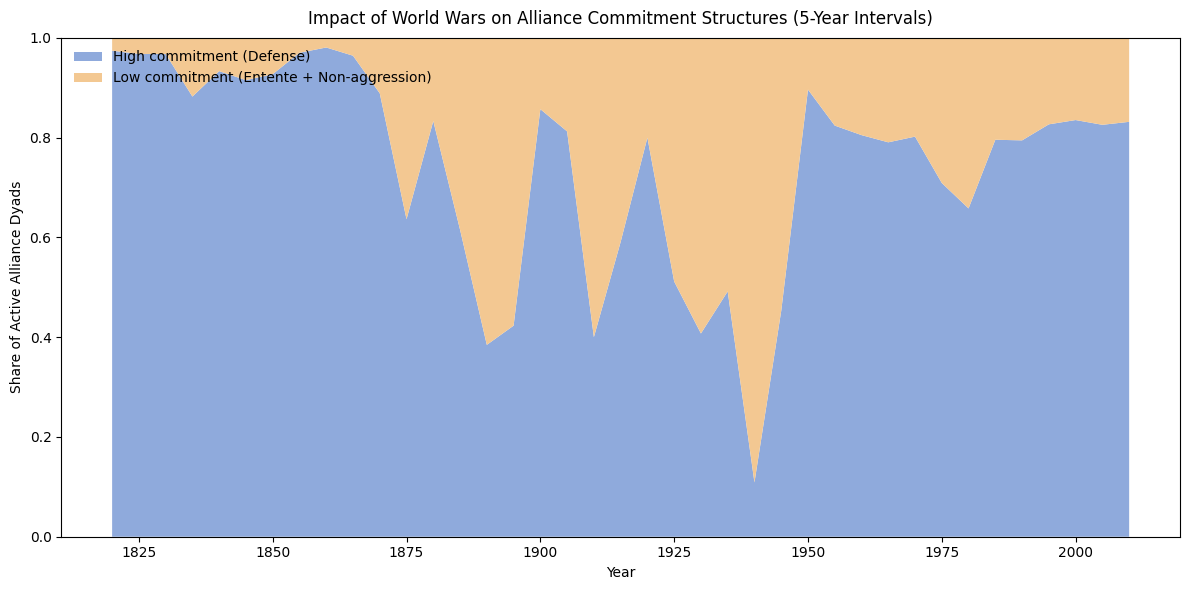

In [73]:
# Initialize the figure for the stacked area chart
# This chart visualizes how high- and low-commitment alliance shares evolve over time
plt.figure(figsize=(12, 6))

# Create a stacked area plot using mutually exclusive commitment shares
# The areas represent the relative composition of alliance commitments in each 5-year interval
plt.stackplot(
    df_commitment_5yr["year"],
    df_commitment_5yr["high_share"],
    df_commitment_5yr["low_share"],
    labels=[
        "High commitment (Defense)",
        "Low commitment (Entente + Non-aggression)"
    ],
    colors=["#8FAADC", "#F3C892"]
)

# Add a descriptive title highlighting the impact of major wars on alliance structures
plt.title(
    "Impact of World Wars on Alliance Commitment Structures (5-Year Intervals)",
    pad=10
)

# Label axes to clarify time scale and measurement
plt.xlabel("Year")
plt.ylabel("Share of Active Alliance Dyads")

# Restrict y-axis to proportional range (0–100%)
plt.ylim(0, 1)

# Add a legend to distinguish commitment categories
plt.legend(loc="upper left", frameon=False)

# Adjust layout to avoid overlap and clipping
plt.tight_layout()

# Save the figure for reproducibility and inclusion in the report
plt.savefig("Area_chart.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [74]:
# Initialize an empty Plotly figure
# This interactive visualization is used to compare high- and low-commitment alliance trends over time
fig = go.Figure()

# Add the high-commitment (defense pact) line
# This line shows the proportion of binding alliance commitments in each 5-year interval
fig.add_trace(
    go.Scatter(
        x=df_commitment_5yr["year"],
        y=df_commitment_5yr["high_share"],
        mode="lines+markers",
        name="High commitment (Defense)",
        line=dict(color="#8FAADC", width=3),
        marker=dict(size=7)
    )
)

# Add the low-commitment (entente + non-aggression) line
# This line captures shifts toward more flexible alliance arrangements over time
fig.add_trace(
    go.Scatter(
        x=df_commitment_5yr["year"],
        y=df_commitment_5yr["low_share"],
        mode="lines+markers",
        name="Low commitment (Entente + Non-aggression)",
        line=dict(color="#F3C892", width=3),
        marker=dict(size=7)
    )
)

# Configure layout settings for clarity and presentation quality
# Includes title placement, axis labels, scale limits, and legend positioning
fig.update_layout(
    title=dict(
        text="Trends in Alliance Commitment Levels Over Time (5-Year Intervals)",
        x=0.5
    ),
    xaxis_title="Year",
    yaxis_title="Share of Active Alliance Dyads",
    yaxis=dict(range=[0, 1]),
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Display the interactive plot
safe_show(fig)

In [75]:
# Define a function to classify each year into a specific war-related regime
# This categorization is used to compare alliance behavior across wartime and non-wartime contexts
def war_regime(year):
    if 1914 <= year <= 1918:
        return "World War I"
    elif 1939 <= year <= 1945:
        return "World War II"
    elif 1919 <= year <= 1938:
        return "Interwar Period"
    else:
        return "Non-War Period"

# Apply the war regime classification to the 5-year commitment dataset
# This adds a contextual label that enables regime-based comparison and distribution analysis
df_commitment_5yr["regime"] = df_commitment_5yr["year"].apply(war_regime)

In [76]:
# Compute the total number of alliance dyad-years for each year
# This represents overall alliance activity using mutually exclusive commitment categories
yearly_commitment["total"] = (
    yearly_commitment["high_commitment"] +
    yearly_commitment["low_commitment"]
)

# Calculate the share of low-commitment alliances for each year
# This metric captures the relative reliance on flexible alliance arrangements
yearly_commitment["low_share"] = (
    yearly_commitment["low_commitment"] /
    yearly_commitment["total"]
)

# Classify each year into a war-related regime (WWI, WWII, Interwar, Non-War)
# This enables comparison of low-commitment alliance behavior across conflict contexts
yearly_commitment["regime"] = yearly_commitment["year"].apply(war_regime)

In [77]:
# Create a filtered dataset for distribution analysis
# This keeps only the war-related regimes of interest
# (Non-War Period, World War I, Interwar Period, World War II)
# The filtered data will be used for KDE / distribution plots
kde_data = yearly_commitment[
    yearly_commitment["regime"].isin(
        ["Non-War Period", "World War I", "Interwar Period", "World War II"]
    )
].copy()

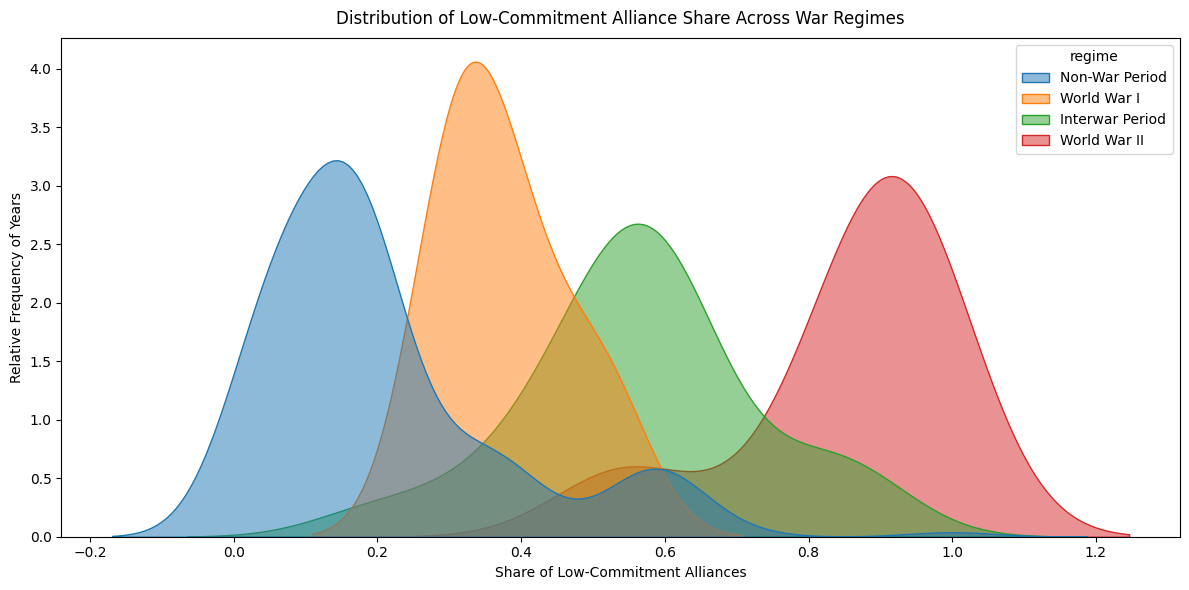

In [78]:
# Initialize the figure for the distribution (KDE) plot
# This visualization compares how low-commitment alliance shares
# are distributed across different war-related regimes
plt.figure(figsize=(12, 6))

# Create Kernel Density Estimation (KDE) plots for each regime
# - x="low_share": proportion of low-commitment alliances in a given year
# - hue="regime": separates distributions by conflict context
# - fill=True: fills the area under each curve for better visual comparison
# - common_norm=False: prevents normalization across regimes,
#   allowing each regime's distribution to be interpreted independently
sns.kdeplot(
    data=kde_data,
    x="low_share",
    hue="regime",
    fill=True,
    common_norm=False,
    alpha=0.5
)

# Add a descriptive title explaining what the distribution represents
plt.title(
    "Distribution of Low-Commitment Alliance Share Across War Regimes",
    pad=10
)

# Label axes to clarify interpretation
plt.xlabel("Share of Low-Commitment Alliances")
plt.ylabel("Relative Frequency of Years")

# Save the figure for reproducibility and report inclusion
plt.savefig("Distribution_graph.png", dpi=300, bbox_inches='tight')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

**Countries with the Highest Alliance Participation**

In [80]:
# Load the Correlates of War alliance dataset again into a new DataFrame
# This separate copy (df1) is used for network analysis to keep it independent
# from earlier transformations applied to df
df1 = pd.read_csv("/Users/snareddy/Desktop/PROJECTS/Story Telling/Datasets/alliance_v4.1_by_dyad_yearly.csv")

# Display the first few rows to inspect the dataset structure
df1.head()

,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,year,version
0,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1816,4.1
1,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1817,4.1
2,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1818,4.1
3,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1819,4.1
4,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1820,4.1


In [81]:
# Extract country names from both sides of the alliance dyad
# state_name1 and state_name2 represent the two countries involved in each alliance
countries_1 = df1[["state_name1"]].rename(columns={"state_name1": "country"})
countries_2 = df1[["state_name2"]].rename(columns={"state_name2": "country"})

# Combine both country columns into a single list
# This ensures that each country is counted regardless of its position in the dyad
country_counts = pd.concat([countries_1, countries_2])

# Count the total number of alliance-years for each country
# Each count represents how often a country appears in alliance dyads over time
country_summary = (
    country_counts
    .value_counts()
    .reset_index(name="alliance_years")
    .rename(columns={"index": "country"})
)

# Select the top 10 countries with the highest number of alliance-years
# These are the most frequently allied states in the dataset
top_countries = country_summary.head(10)

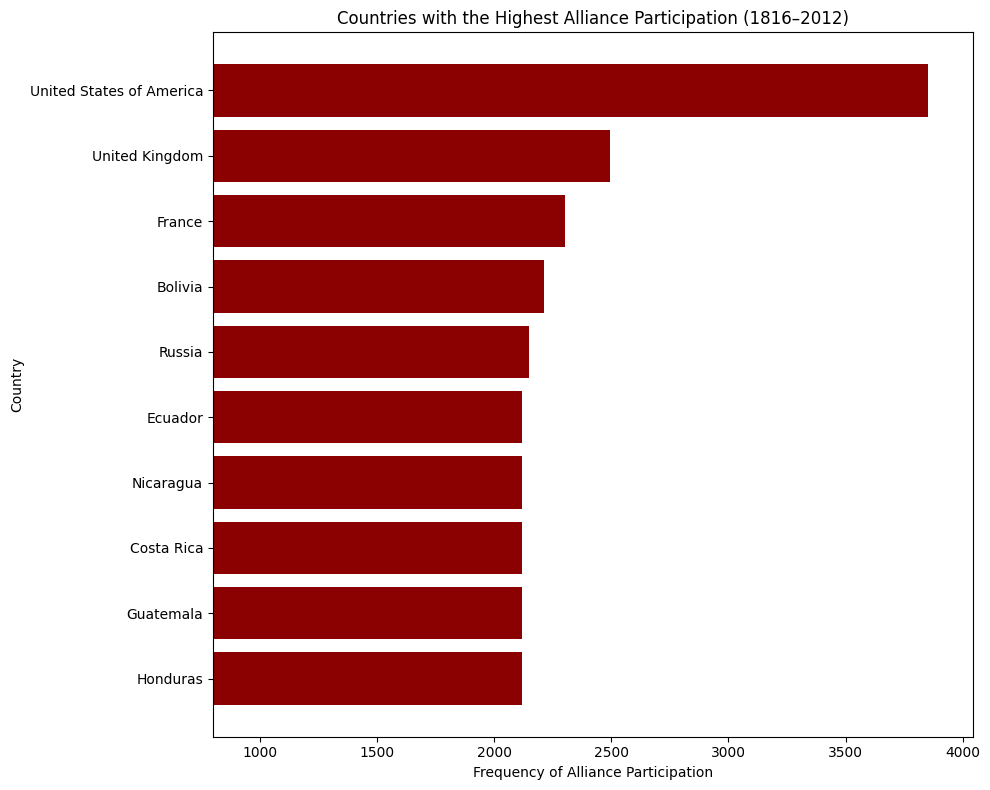

In [82]:
# Initialize the figure for a horizontal bar chart
# This visualization highlights countries with the highest alliance participation
plt.figure(figsize=(10, 8))

# Create a horizontal bar chart showing alliance participation frequency
# - y-axis: country names
# - x-axis: number of alliance-years
plt.barh(
    top_countries["country"],
    top_countries["alliance_years"],
    color="#8B0000"
)

# Label axes to clarify what is being measured
plt.xlabel("Frequency of Alliance Participation")
plt.ylabel("Country")

# Add a descriptive title summarizing the scope and time period
plt.title("Countries with the Highest Alliance Participation (1816–2012)")

# Invert the y-axis so the country with the highest participation appears at the top
plt.gca().invert_yaxis()

# Set the x-axis lower limit to focus on highly active countries
plt.xlim(800)

# Adjust layout to avoid clipping of labels
plt.tight_layout()
plt.savefig("Frequency_of_alliance_participation.png", dpi=300, bbox_inches='tight')
# Display the plot
plt.show()


**The Network Graphs**

In [83]:
# Define a set of core NATO member countries
# This list is used to filter alliance data and construct the NATO-specific network
# Focusing on major members helps reduce visual clutter and highlight alliance structure
nato_countries = {
    "United States", "United Kingdom", "France", "Germany",
    "Italy", "Canada", "Belgium", "Netherlands", "Luxembourg",
    "Norway", "Denmark", "Portugal", "Spain", "Greece", "Turkey"
}

In [84]:
# Filter the dataset to include only alliance dyads where both states are NATO members
# This isolates NATO-specific relationships from the full alliance dataset
nato_df = df1[
    df1["state_name1"].isin(nato_countries) &
    df1["state_name2"].isin(nato_countries)
]

# Initialize an undirected graph for the NATO alliance network
# Nodes represent countries and edges represent alliance ties
G_nato = nx.Graph()

# Add edges to the graph for each NATO alliance dyad
# Each edge connects two NATO member states that share an alliance
for _, row in nato_df.iterrows():
    G_nato.add_edge(row["state_name1"], row["state_name2"])

In [85]:
# Compute node positions using a spring layout
# This layout positions nodes so that connected countries are closer together,
# making alliance structure visually interpretable
pos = nx.spring_layout(G_nato, seed=42)

# Edges --------------------

# Prepare lists to store edge coordinates for Plotly
edge_x = []
edge_y = []

# Loop through each alliance tie (edge) in the NATO network
# Extract the x and y coordinates of the two connected countries
for u, v in G_nato.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    # Add coordinates for a line segment, with None to break between edges
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create a Plotly scatter trace for edges
# Edges are drawn as light gray lines to emphasize structure without overpowering nodes
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color="#B0B0B0"),
    hoverinfo="none",
    mode="lines"
)

# Nodes --------------------

# Prepare lists to store node coordinates and labels
node_x = []
node_y = []
node_text = []

# Loop through each NATO country (node) in the network
# Collect position coordinates and country names
for node in G_nato.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

# Create a Plotly scatter trace for nodes
# Nodes are styled in blue to represent NATO countries
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    text=node_text,
    textposition="top center",
    hoverinfo="text",
    marker=dict(
        size=18,
        color="#4C78A8",
        line=dict(width=1, color="white")
    )
)

# Figure Layout --------------------

# Combine edge and node traces into a single interactive figure
# Axes and gridlines are removed to keep focus on the network structure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="NATO Alliance Network (Cold War Period)",
        title_x=0.5,
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

# Display the interactive NATO network graph
safe_show(fig)

In [86]:
# Define a curated set of key Warsaw Pact member and successor states
# This list focuses on historically significant countries to construct
# a clear and interpretable Warsaw Pact alliance network
warsaw_countries = {
    "Russia",
    "Poland",
    "Czechoslovakia",
    "German Democratic Republic",
    "Hungary",
    "Romania",
    "Bulgaria",
    "Albania",
    "Yugoslavia",
    "Ukraine",
    "Belarus",
    "Lithuania",
    "Latvia",
    "Estonia",
    "Kazakhstan"
}

In [87]:
# Filter the dataset to include only alliance dyads where both states
# belong to the selected Warsaw Pact country set
# This isolates Warsaw-specific alliance relationships for network analysis
warsaw_df = df1[
    df1["state_name1"].isin(warsaw_countries) &
    df1["state_name2"].isin(warsaw_countries)
]

In [88]:
# Initialize an undirected graph for the Warsaw Pact alliance network
# Nodes represent countries and edges represent alliance ties
G_warsaw = nx.Graph()

# Add edges to the graph for each Warsaw Pact alliance dyad
# Each edge connects two Warsaw member states with an alliance relationship
for _, row in warsaw_df.iterrows():
    G_warsaw.add_edge(row["state_name1"], row["state_name2"])

# Compute degree centrality for each country in the network
# Degree centrality measures how connected a country is within the alliance network
centrality = nx.degree_centrality(G_warsaw)

# Scale node sizes based on centrality
# More central countries appear larger in the network visualization
node_sizes = [3000 * centrality[n] for n in G_warsaw.nodes()]

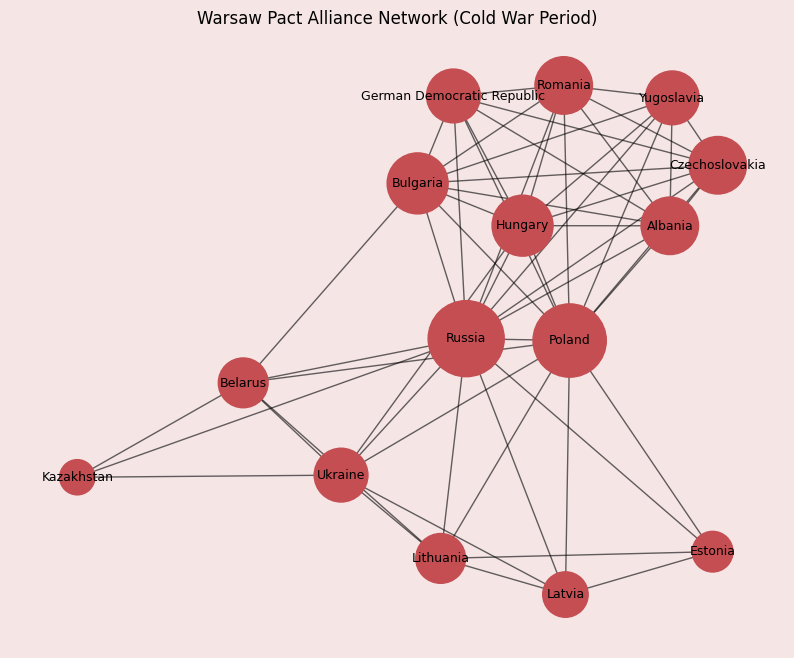

<Figure size 640x480 with 0 Axes>

In [89]:
# Create a matplotlib figure and axis with a light background color
# The soft background helps visually distinguish the Warsaw Pact network
fig, ax = plt.subplots(figsize=(10, 8), facecolor="#F5E5E5")
ax.set_facecolor("#F5E5E5")

# Compute node positions using a spring layout
# This layout places more strongly connected countries closer together
pos = nx.spring_layout(G_warsaw, seed=42)

# Draw the nodes (countries) in the Warsaw Pact network
# Node size reflects degree centrality (importance within the network)
# Red color is used to visually distinguish the Warsaw Pact
nx.draw_networkx_nodes(
    G_warsaw,
    pos,
    node_size=node_sizes,
    node_color="#C44E52"   # red for Warsaw Pact countries
)

# Draw the edges (alliance ties) between countries
# Black edges with slight transparency emphasize structure without clutter
nx.draw_networkx_edges(
    G_warsaw,
    pos,
    edge_color="black",
    alpha=0.6
)

# Add labels for each country to aid interpretation
nx.draw_networkx_labels(
    G_warsaw,
    pos,
    font_size=9
)

# Add a descriptive title for the network visualization
plt.title("Warsaw Pact Alliance Network (Cold War Period)")

# Remove axes for a cleaner network-focused visualization
plt.axis("off")

# Display the network graph
plt.show()

# Save the figure for reproducibility and inclusion in the report
plt.savefig("Warsaw_pact.png", dpi=300, bbox_inches='tight')